In [1]:
import requests
import json
import jsondiff
import numpy as np
import matplotlib.pyplot as plt
import smopy
from numpy.random import default_rng
import scipy.spatial.distance
import scipy.stats

In [2]:
def load_locations():
    
    baseurl = 'https://api.criticalmaps.net/'
    r =requests.post(baseurl)
    #print(r.status_code,r.headers)
    jp = json.loads(r.text)
    print(r.text)
    return jp

In [3]:
mapEU = smopy.Map((50., 6., 55., 15.), z=4)

Lowered zoom level to keep map size reasonable. (z = 12)


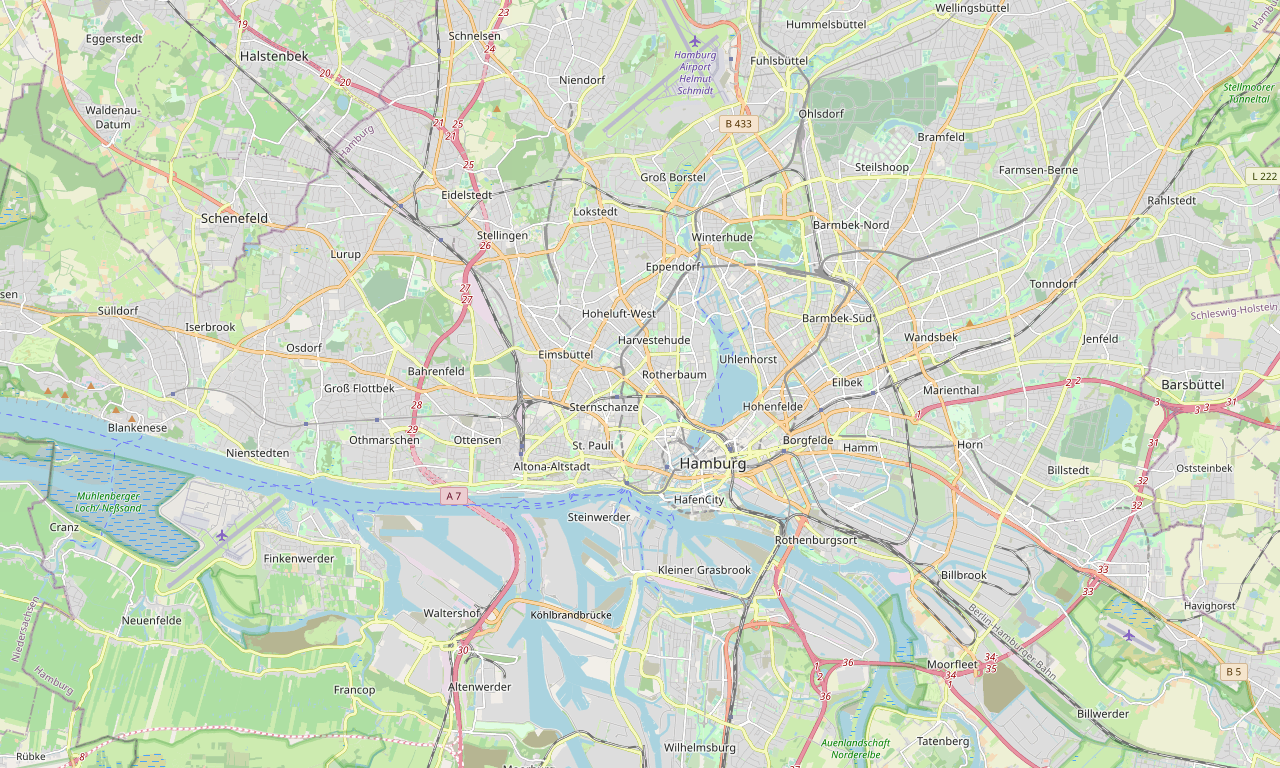

In [4]:
mapHH = smopy.Map((53.5, 9.85, 53.62, 10.1), z=13)
mapHH.show_ipython()

In [5]:
def get_current_positions():
    r0 = load_locations()
    locations = r0['locations']
    positions = np.empty((0,2));
    for ident in locations:
        loc = locations[ident]
        positions=np.append(positions,[[loc['latitude']*1e-6,loc['longitude']*1e-6]],axis=0)
    return positions

{"locations":{"1e558c1cadaf1642658c4198d73e58e3ad114b44":{"longitude":-1562818,"latitude":47229031,"timestamp":1668890299,"name":null,"color":null},"f2f8613528bafa3260b566a3d722994c4c105504":{"longitude":-58418715,"latitude":-34566930,"timestamp":1668890271,"name":null,"color":null},"e1ef27c5cda2db6d4eea5b6cffd99df3ab09eaaa":{"longitude":9874360,"latitude":53643587,"timestamp":1668890330,"name":null,"color":null},"d2f40c4ac35928ed31f50b8da756a96191508649":{"longitude":12564486,"latitude":41887480,"timestamp":1668890331,"name":null,"color":null},"88394a38048a92b0241e6abf4a8cd75dc637b0fc":{"longitude":12511168,"latitude":41886003,"timestamp":1668890332,"name":null,"color":null},"f7dcb82107cc6a32747195041bd5b7829942e858":{"longitude":6959292,"latitude":51419066,"timestamp":1668890333,"name":null,"color":null},"4277e37814f548208d82869ac35f3f3eeba85b9d5787f5597dc8a1d0d599b0c1f908b9070a112f5076023b6b7ff5c093137d9b9c05ceaee4760caa6874514342":{"longitude":18268816,"latitude":59354867,"timestam

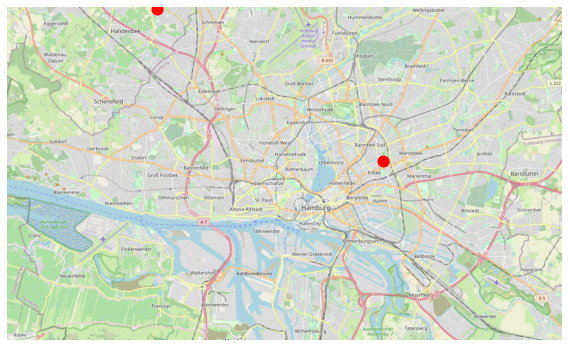

In [6]:
positions = get_current_positions();
positions_px_x,positions_px_y = mapHH.to_pixels(positions[:,0],positions[:,1])
ax = mapHH.show_mpl(figsize=(8, 6))
ax.plot(positions_px_x,positions_px_y, 'or', ms=10, mew=2);

In [9]:
positions[:,1]

array([ -1.562818, -58.418715,   9.87436 ,  12.564486,  12.511168,
         6.959292,  18.268816,   7.436459,  10.054102])

ValueError: x and y must be the same size

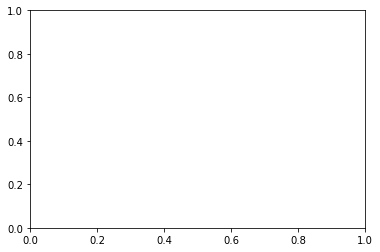

In [8]:
#Testing clustering, lets create some points
testp = np.array([[-2, -2], [-1.5, -1.25], [-1,-1],[0,0],[0.5,0.1],[1,0],[1.1,-0.2],[2,0],[3.05,0]])
labels_true = np.ones(np.shape(positions))
rng = default_rng(3453453)
testp = np.append(testp,(rng.random((5,2))-0.5)*50,axis=0)
labels_true = np.append(labels_true,np.ones((5,2))*2)
plt.scatter(positions[:,0],testp[:,1])
plt.show()
spatial_distances = scipy.spatial.distance.cdist(testp,testp)

# All unique distances:
#spatial_distances = np.triu(spatial_distances)

# Only minimal distance for each object (except the distance to itself)
# Partition with k=1 places second smallest object at position 1
spatial_distances_min = np.partition(spatial_distances,1,axis=1)[:,1]
counts,edges = np.histogram(spatial_distances_min,bins='auto')
plt.stairs(counts,edges,fill=True)
plt.show()

In [ ]:
testp = positions
plt.scatter(positions[:,1],positions[:,0])
plt.show()

In [ ]:
np.logical_and(np.all(np.array([[0.5,2],[0.4,1]]) > np.array([[0.33,1.5]]), axis=1),np.all(np.array([[0.5,2],[0.4,1]]) < np.array([[2,1.5]]), axis=1))

In [ ]:
positions>(53.5,9.85) && positions<(53.62,10.1)

In [ ]:
#Testing clustering, lets create some points                
only_HH = np.logical_and(np.all(positions > np.array([[53.5,9.85]]), axis=1),np.all(positions < np.array([[53.62,10.1]]), axis=1))
testp = positions[only_HH,:]
plt.scatter(testp[:,0],testp[:,1])
plt.show()
spatial_distances = scipy.spatial.distance.cdist(testp,testp)

# All unique distances:
#spatial_distances = np.triu(spatial_distances)

# Only minimal distance for each object (except the distance to itself)
# Partition with k=1 places second smallest object at position 1
spatial_distances_min = np.partition(spatial_distances,1,axis=1)[:,1]
counts,edges = np.histogram(spatial_distances_min,bins='auto')
plt.stairs(counts,edges,fill=True)
plt.show()

In [ ]:
y = sorted(spatial_distances_min,reverse=True)
print(y)
plt.plot(range(1,len(y)+1),y)
from kneed import KneeLocator
kneedle = KneeLocator(range(1,len(y)+1),  #x values
                      y, # y values
                      S=1.0, #parameter suggested from paper
                      curve="convex", #parameter from figure
                      direction="decreasing") #parameter from figure
kneedle.plot_knee_normalized()
# https://stats.stackexchange.com/questions/88872/a-routine-to-choose-eps-and-minpts-for-dbscan
print('Optimal value for epsilon:', kneedle.knee_y)
epsilon=kneedle.knee_y

In [ ]:
# Scrapped: Calculate total mean distance to all other points
N = np.shape(testp)[0]
test = np.sum(spatial_distances/2,axis=1)/N
counts,edges = np.histogram(test,bins=50)
plt.stairs(counts,edges,fill=True)
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN, OPTICS
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# Compute DBSCAN
db = DBSCAN(eps=epsilon*0.2, min_samples=5).fit(testp) # Factor 2: try and error with my test data, TODO
# Alternative, finds core sample and does not need eps parameter
# db = OPTICS(min_samples=3).fit(testp)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Estimated number of noise points: %d" % n_noise_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
#print(
#    "Adjusted Mutual Information: %0.3f"
#    % metrics.adjusted_mutual_info_score(labels_true, labels)
#)
#print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [ ]:
import geopy.distance
selp_la = testp[labels==0]
center_la = np.mean(selp_la,axis=0)
max_la = np.max(selp_la,axis=0)
min_la = np.min(selp_la,axis=0)
selp = np.zeros(np.shape(selp_la))
p = Proj(proj='utm',zone=10,ellps='WGS84', preserve_units=False)
center = np.array(p(center_la[0],center_la[1]))
for ii,coord in enumerate(selp_la):
    #selp[ii,:] = geopy.distance.geodesic(coord,center).km
    selp[ii,:] = np.array(p(coord[0],coord[1])) - center
plt.scatter(selp[:,0],selp[:,1])
selp

In [ ]:
map_zoom = smopy.Map((min_la[0],min_la[1], max_la[0], max_la[1]), z=14)
positions_px_x,positions_px_y = map_zoom.to_pixels(selp_la[:,0],selp_la[:,1])
ax = map_zoom.show_mpl(figsize=(8, 6))
ax.plot(positions_px_x,positions_px_y, 'or', ms=10, mew=2);

In [ ]:
sorted_points = []
sorted_mark = np.array(np.zeros(np.size(selp,0)),dtype=bool)
sorted_points = np.empty(np.shape(selp))
sorted_points[:] = np.nan
jj = 0
first_point = np.argmin(selp[:,0])
print(first_point,selp[first_point,:])
sorted_points[jj,:] = selp[first_point,:]
#Mark first point as sorted
sorted_mark[first_point] = True
while not np.all(sorted_mark):
    #print(jj)
    cp = sorted_points[jj,:]
    unsorted_points = selp.copy()
    unsorted_points[sorted_mark,:] = [np.nan,np.nan]
    d = np.sqrt((unsorted_points[:,0]-cp[0])**2 + (unsorted_points[:,1]-cp[1])**2)
    ii = np.nanargmin(d)
    jj = jj + 1
    sorted_points[jj,:] = unsorted_points[ii]
    sorted_mark[ii] = True
#Roll array such that first element has minimum first coordinate
#roll_ii = np.argmin(sorted_points[:,0])
#print(roll_ii)
#sorted_points = np.roll(sorted_points,roll_ii,axis=0)

In [ ]:
from scipy.interpolate import interp1d
spl = interp1d(sorted_points[:,0],sorted_points[:,1],kind='slinear')
plt.plot(sorted_points[:,0],sorted_points[:,1],'o', sorted_points[:,0], spl(sorted_points[:,0]),'-')
plt.show()

In [ ]:
from scipy import interpolate
#https://scipy.github.io/devdocs/tutorial/interpolate.html
x,y = sorted_points[:,0],sorted_points[:,1]
tck, u = interpolate.splprep([x, y], s=0.001)
unew = np.arange(0, 1.01,0.01)
out = interpolate.splev(unew, tck)
plt.plot(x, y, 'x', out[0], out[1],'b')
plt.legend(['Points','Fit'])
#plt.axis([-1.05, 1.05, -1.05, 1.05])
plt.show()
# Calculate length
diffs = np.sqrt((out[0][:-1] - out[0][1:])**2 + (out[1][:-1] - out[1][1:])**2)
length = sum(diffs)
print('Length:', length)


In [ ]:
#https://stackoverflow.com/questions/52014197/how-to-interpolate-a-2d-curve-in-python
COntinue HERE: http://www.ipol.im/pub/art/2019/234/
https://scicomp.stackexchange.com/questions/27649/algorithms-to-extract-trajectory-lines-out-of-3d-point-clouds